# Import

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import csv
import seaborn as sns

# Loading the dataset

In [40]:
chemin = 'exchange_rate_with_missing.csv'

# Charger le jeu de données depuis un fichier CSV
df = pd.read_csv(chemin)

print(df.head())

            date       0       1         2         3         4         5  \
0  1990/1/1 0:00  0.7855  1.6110  0.861698  0.634196  0.211242  0.006838   
1  1990/1/2 0:00  0.7818  1.6100  0.861104  0.633513  0.211242  0.006863   
2  1990/1/3 0:00  0.7867  1.6293  0.861030  0.648508  0.211242  0.006975   
3  1990/1/4 0:00  0.7860  1.6370  0.862069  0.650618  0.211242  0.006953   
4  1990/1/5 0:00  0.7849  1.6530  0.861995  0.656254       NaN  0.006940   

          6  OT  
0  0.525486 NaN  
1  0.523972 NaN  
2  0.526316 NaN  
3  0.523834 NaN  
4  0.527426 NaN  


In [41]:
date_time = pd.to_datetime(df.pop('date'), format='%Y/%m/%d %H:%M')

print(df.head())

        0       1         2         3         4         5         6  OT
0  0.7855  1.6110  0.861698  0.634196  0.211242  0.006838  0.525486 NaN
1  0.7818  1.6100  0.861104  0.633513  0.211242  0.006863  0.523972 NaN
2  0.7867  1.6293  0.861030  0.648508  0.211242  0.006975  0.526316 NaN
3  0.7860  1.6370  0.862069  0.650618  0.211242  0.006953  0.523834 NaN
4  0.7849  1.6530  0.861995  0.656254       NaN  0.006940  0.527426 NaN


# Data Analysis

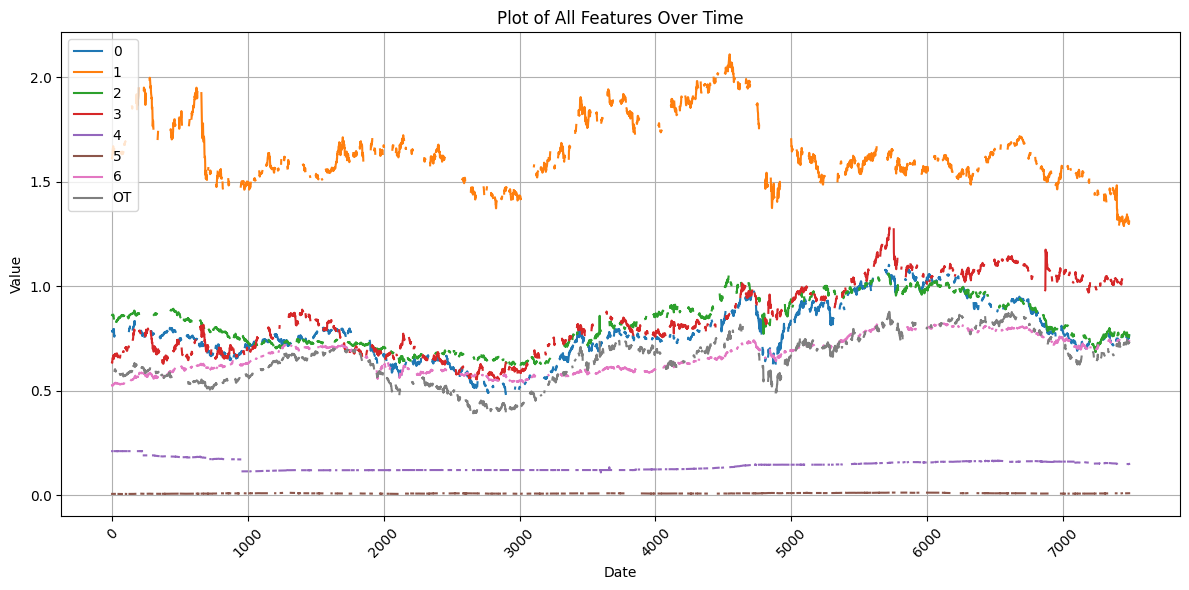

In [42]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title('Plot of All Features Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

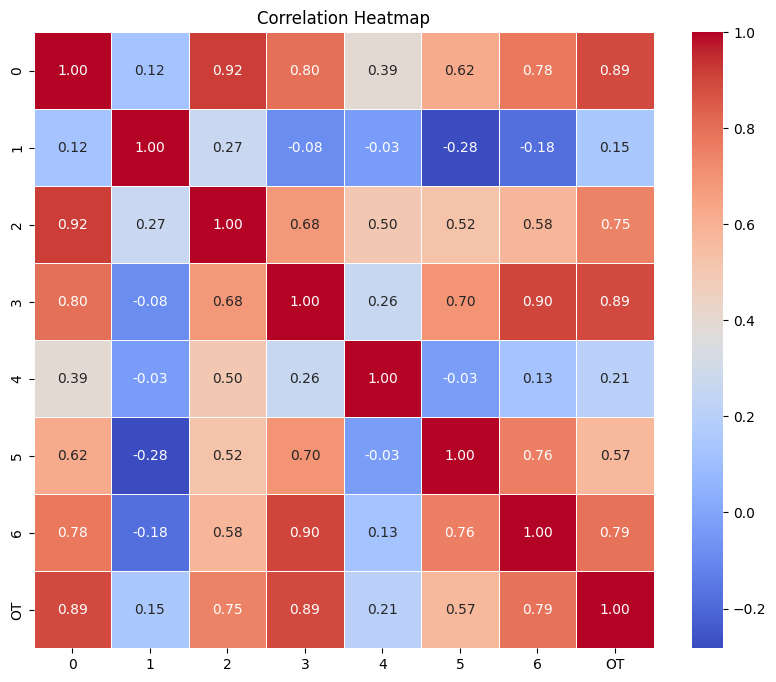

In [43]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [44]:
# Donne une idée de la répartition des valeurs
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,3331.0,0.781006,0.129522,0.484742,0.698400,0.762950,0.878137,1.102536
1,3313.0,1.639203,0.159019,1.288170,1.541545,1.608105,1.703737,2.109000
2,3327.0,0.814416,0.115108,0.620155,0.724375,0.798062,0.898096,1.060760
3,3326.0,0.835148,0.171885,0.549739,0.685584,0.801539,0.988861,1.279541
4,3466.0,0.141770,0.023865,0.109292,0.120809,0.135084,0.159895,0.211242
5,3392.0,0.009434,0.001552,0.006275,0.008328,0.009215,0.010147,0.013043
6,3191.0,0.661915,0.082407,0.523834,0.590249,0.641766,0.724533,0.832556
OT,3257.0,0.643647,0.117786,0.393153,0.554650,0.652500,0.716589,0.877501


In [45]:
#df = df[['6']]
df = df.drop('OT', axis=1)
df = df.drop('1', axis=1)
df = df.drop('4', axis=1)
df = df.drop('5', axis=1)

# Fill-in missing values

In [46]:
# Fill missing values by linear interpolation
df.interpolate(method='linear', inplace=True)

# Fill leading and trailing values, since linear needs surrounding values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

C:\Users\doria\AppData\Local\Temp\ipykernel_7104\2183291073.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\doria\AppData\Local\Temp\ipykernel_7104\2183291073.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [47]:
nan_counts = df.isna().sum()

print(nan_counts)

0    0
2    0
3    0
6    0
dtype: int64


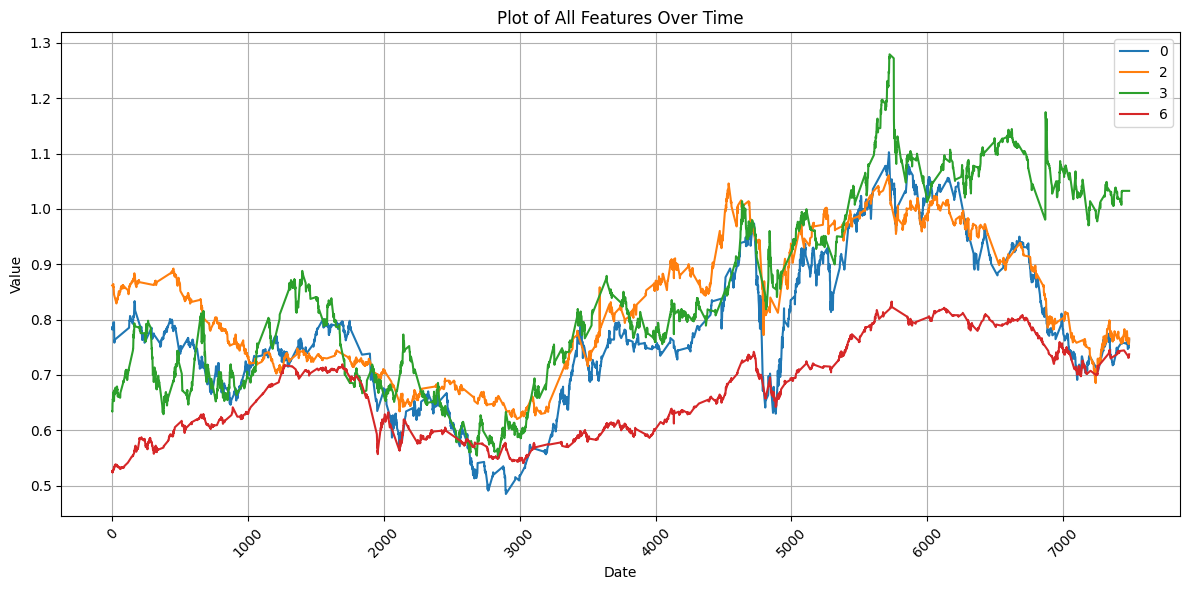

In [48]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title('Plot of All Features Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

# Data splitting

In [49]:
n=len(df)

# Séparation des données en ensemble d'entraînement, de validation et de test
train_df = df[0:int(n*0.7)]  # 70% des données pour l'entraînement
val_df = df[int(n*0.7):int(n*0.9)]  # 20% des données pour la validation
test_df = df[int(n*0.9):]  # 10% des données pour les tests

# Data Normalization

In [50]:
# # Calcul de la moyenne et de l'écart type des données d'entraînement
# train_mean = train_df.mean()
# train_std = train_df.std()

# # Normalisation des données d'entraînement, de validation et de test
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std
# last1000_df = (last1000_df - train_mean) / train_std
# last1100_df = (last1100_df - train_mean) / train_std

# Data preparation for training

In [62]:
import numpy as np

# Fonction utilisé pour retourner l'ensemble pour la prédiction finale.
def df_to_X(df, window_size=500):
  df_as_np = df.to_numpy()
  X = []
  row = [r for r in df_as_np[0:0+window_size]]
  X.append(row)
    
  return np.array(X)

# Fonction qui crée des ensembles pour les données avec une fenêtre glissante
# et des étiquettes pour une certaine taille de fenêtre, étiquette, décalage et pas.
def df_to_X_y2(df, window_size=500, label_size=100, offset=10, step=1):
    # Convertir le dataframe en une matrice numpy pour un accès plus rapide
    df_as_np = df.to_numpy()
    X = []  # Pour stocker les données
    y = []  # Pour stocker les étiquettes de prédiction
    
    # Itérer sur le dataframe en créant des fenêtres glissantes
    for i in range(0, len(df_as_np) - window_size - label_size, step):
        # Créer une sous-liste de taille window_size
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)  # Ajouter la sous-liste aux données d'entraînement
        
        # Créer les étiquettes en tenant compte du décalage et de la taille des étiquettes
        label = df_as_np[i + window_size - offset:i + window_size + label_size]
        label = [sous_liste[-1] for sous_liste in label]  
        y.append(label)  # Ajouter les étiquettes aux données de prédiction
    
    # Retourner les ensembles et les prédictions sous forme de tableaux numpy
    return np.array(X), np.array(y)

# Fonction qui crée des ensembles pour chaque colonne individuellement
# Retourne autant de liste que de colonne
def df_to_X_y3(df, window_size=500, label_size=100, offset=10, step=1):
    # Convertir le dataframe en une matrice numpy
    df_as_np = df.to_numpy()
    
    # Initialiser des listes pour stocker les données et les étiquettes pour chaque colonne
    X = [[] for _ in range(len(df.columns))]
    y = [[] for _ in range(len(df.columns))]
    
    # Itérer sur le dataframe pour chaque fenêtre glissante
    for i in range(0, len(df_as_np) - window_size - label_size, step):
        # Pour chaque colonne dans le dataframe
        for j in range(len(df.columns)):
            # Obtenir la fenêtre glissante pour une colonne spécifique
            row = [r[j] for r in df_as_np[i:i + window_size]]
            X[j].append(row)  # Ajouter la sous-liste aux données de cette colonne
            
            # Obtenir les étiquettes pour la même colonne
            label = df_as_np[i + window_size - offset:i + window_size + label_size, j]
            label = [value for value in label]
            y[j].append(label)  # Ajouter les étiquettes aux données de prédiction de cette colonne
    
    # Retourner les ensembles d'entraînement et de prédiction pour chaque colonne sous forme de tableaux numpy
    return [np.array(col_X) for col_X in X], [np.array(col_y) for col_y in y]


In [69]:
X_train,y_train = df_to_X_y2(train_df,window_size=500,label_size=100,offset=0,step=1)
X_val,y_val = df_to_X_y2(val_df,window_size=500,label_size=100,offset=0,step=1)
X_test,y_test = df_to_X_y2(test_df,window_size=500,label_size=100,offset=0,step=1)

In [70]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4641, 500, 4),
 (4641, 100),
 (898, 500, 4),
 (898, 100),
 (149, 500, 4),
 (149, 100))

# Model

In [54]:
MAX_EPOCHS = 300

def compile_and_fit(model):
    # Définition du callback pour l'arrêt
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # Entraînement du modèle avec les données d'entraînement et de validation
    history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return history


## LSTM

In [71]:
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, LSTM, Flatten, Dense, Dropout, Concatenate
from keras.models import Model

def def_model_LSTM():
    input_shape = (X_train.shape[1],X_train.shape[2])
    input_layer = Input(shape=input_shape)

    # Ajout de la couche LSTM avec dropout
    lstm_layer = LSTM(units=1024, return_sequences=True)(input_layer)
    lstm_layer = Dropout(0.2)(lstm_layer)

    # Application de la couche Flatten
    lstm_layer = Flatten()(lstm_layer)
    # Ajout d'une couche Dense avec dropout
    lstm_layer = Dense(units=y_train.shape[1])(lstm_layer)
    # Création du modèle avec l'entrée et la sortie
    model = Model(inputs=input_layer, outputs=lstm_layer)

    # Affichage du résumé du modèle
    model.summary()

    return model

## XGBOOST (BAD)

In [72]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split

# # Remodeler les données d'entraînement pour les rendre bidimensionnelles
# X_train_2d = X_train.reshape((X_train.shape[0], -1))  # Fusionner les deuxième et troisième dimensions
# y_train_2d = y_train.reshape((y_train.shape[0], -1))  # Fusionner les deuxième et troisième dimensions

# # Remodeler les données de test de la même manière
# X_val_2d = X_val.reshape((X_val.shape[0], -1))  # Fusionner les deuxième et troisième dimensions
# y_val_2d = y_val.reshape((y_val.shape[0], -1))  # Fusionner les deuxième et troisième dimensions

# # Remodeler les données de test de la même manière
# X_test_2d = X_test.reshape((X_test.shape[0], -1))  # Fusionner les deuxième et troisième dimensions
# y_test_2d = y_test.reshape((y_test.shape[0], -1))  # Fusionner les deuxième et troisième dimensions

# # Convertir les données remodelées dans la structure de données spécifique à XGBoost (DMatrix)
# dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train_2d)
# dtest_2d = xgb.DMatrix(X_test_2d, label=y_test_2d)
# dval_2d = xgb.DMatrix(X_val_2d, label=y_val_2d)

# # Entraîner le modèle avec les données remodelées
# num_rounds = 100
# # Définir les ensembles de validation
# eval_set = [(X_val_2d, y_val_2d)]

# # Initialiser le modèle XGBoost avec les paramètres souhaités
# model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

# # Entraîner le modèle en utilisant les ensembles de validation
# model.fit(X_train_2d, y_train_2d, eval_set=eval_set, verbose=True)

In [73]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split

# # Définir les paramètres du modèle XGBoost
# params = {
#     'objective': 'reg:squarederror',  # Utiliser la régression comme objectif
#     'eval_metric': 'mae',  # Utiliser l'erreur absolue moyenne comme métrique
#     'learning_rate': 0.1,  # Réduire le taux d'apprentissage
#     'max_depth': 6,  # Limiter la profondeur maximale de l'arbre
#     'min_child_weight': 1,  # Réduire le nombre minimum d'échantillons requis pour diviser un nœud
#     'colsample_bytree': 0.8  # Utiliser un sous-échantillonnage des colonnes lors de la création de chaque arbre
# }

# # Remodeler les données d'entraînement pour les rendre bidimensionnelles
# X_train_2d = X_train.reshape((X_train.shape[0], -1))  
# y_train_2d = y_train.reshape((y_train.shape[0], -1))  

# # Remodeler les données de test de la même manière
# X_test_2d = X_test.reshape((X_test.shape[0], -1))  
# y_test_2d = y_test.reshape((y_test.shape[0], -1))  

# # Convertir les données remodelées dans la structure de données spécifique à XGBoost (DMatrix)
# dtrain_2d = xgb.DMatrix(X_train_2d, label=y_train_2d)
# dtest_2d = xgb.DMatrix(X_test_2d, label=y_test_2d)

# # Entraîner le modèle avec les données remodelées
# num_rounds = 100
# evals = [(dtest_2d, 'eval'), (dtrain_2d, 'train')]  # Utiliser les données de test pour l'évaluation
# bst = xgb.train(params, dtrain_2d, num_rounds, evals, verbose_eval=10)  # Afficher les performances toutes les 10 itérations

# # Faire des prédictions sur l'ensemble de test
# y_pred_2d = bst.predict(dtest_2d)


## CNN

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, concatenate

def def_model_CNN():

    # Définition de l'entrée du modèle
    input_shape = (X_train.shape[1],X_train.shape[2])
    input_layer = Input(shape=input_shape)

    # Branche CNN
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(input_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(conv_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(conv_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Flatten()(conv_layer)

    conv_layer = Dense(units=512)(conv_layer)
    # Couche Dense finale
    output_layer = Dense(units=y_train.shape[1])(conv_layer)

    # Création du modèle avec l'entrée et la sortie
    model = Model(inputs=input_layer, outputs=output_layer)

    # Affichage du résumé du modèle
    model.summary()

    return model

## CNN + LSTM (Multibranch)

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, concatenate

def def_model_CNN_LSTM():

    # Définition de l'entrée du modèle
    input_shape = (X_train.shape[1],X_train.shape[2])
    input_layer = Input(shape=input_shape)

    # Branche CNN
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(input_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(conv_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Conv1D(filters=512, kernel_size=35, activation='relu')(conv_layer)
    conv_layer = MaxPooling1D(pool_size=2)(conv_layer)
    conv_layer = Flatten()(conv_layer)
    conv_branch_output = Dense(units=100)(conv_layer)

    # Branche LSTM
    lstm_layer = LSTM(units=1024, return_sequences=True)(input_layer)
    lstm_layer = Flatten()(lstm_layer)
    lstm_branch_output = Dense(units=100)(lstm_layer)

    # Fusion des sorties des deux branches
    merged_layer = concatenate([conv_branch_output, lstm_branch_output])
    merged_layer = Dense(units=512)(merged_layer)
    # Couche Dense finale
    output_layer = Dense(units=y_train.shape[1])(merged_layer)

    # Création du modèle avec l'entrée et la sortie
    model = Model(inputs=input_layer, outputs=output_layer)

    # Affichage du résumé du modèle
    model.summary()

    return model

# Training Model

In [76]:
model1 = def_model_LSTM()
history1 = compile_and_fit(model1)

model2 = def_model_CNN_LSTM()
history2 = compile_and_fit(model2)

model3 = def_model_CNN()
history3 = compile_and_fit(model3)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500, 4)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 500, 1024)         4214784   
                                                                 
 dropout_3 (Dropout)         (None, 500, 1024)         0         
                                                                 
 flatten_9 (Flatten)         (None, 512000)            0         
                                                                 
 dense_15 (Dense)            (None, 100)               51200100  
                                                                 
Total params: 55,414,884
Trainable params: 55,414,884
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
73/73 [============================

# SAVE & LOAD

In [187]:
# # Sauvegarder le modèle complet au format HDF5
#model.save('modelDS/model123.h5')

In [5]:
# from keras.models import load_model

# model = load_model('model1_1.h5',compile=False)

# Graphes + predictions + csv

In [81]:
def plot_metrics(history):
    fig, axs = plt.subplots(1,2, figsize=(25,5))

    axs[0].plot(history.history['loss'], label='Train MSE')
    axs[0].plot(history.history['val_loss'], label='Val MSE')
    axs[0].set_ylabel('MSE Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].legend()

    axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
    axs[1].plot(history.history['val_mean_absolute_error'], label='Val MAE')
    axs[1].set_ylabel('MAE Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    plt.show()

def evaluate(model):
    # Évaluer le modèle pour chaque ensemble de données
    train_mse,train_mae = model.evaluate(X_train, y_train, verbose=0)
    val_mse,val_mae = model.evaluate(X_val, y_val, verbose=0)
    test_mse,test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Afficher les résultats pour l'ensemble d'entraînement
    print("Ensemble d'entraînement:")
    print(f"MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    
    # Afficher les résultats pour l'ensemble de validation
    print("Ensemble de validation:")
    print(f"MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")
    
    # Afficher les résultats pour l'ensemble de test
    print("Ensemble de test:")
    print(f"MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")


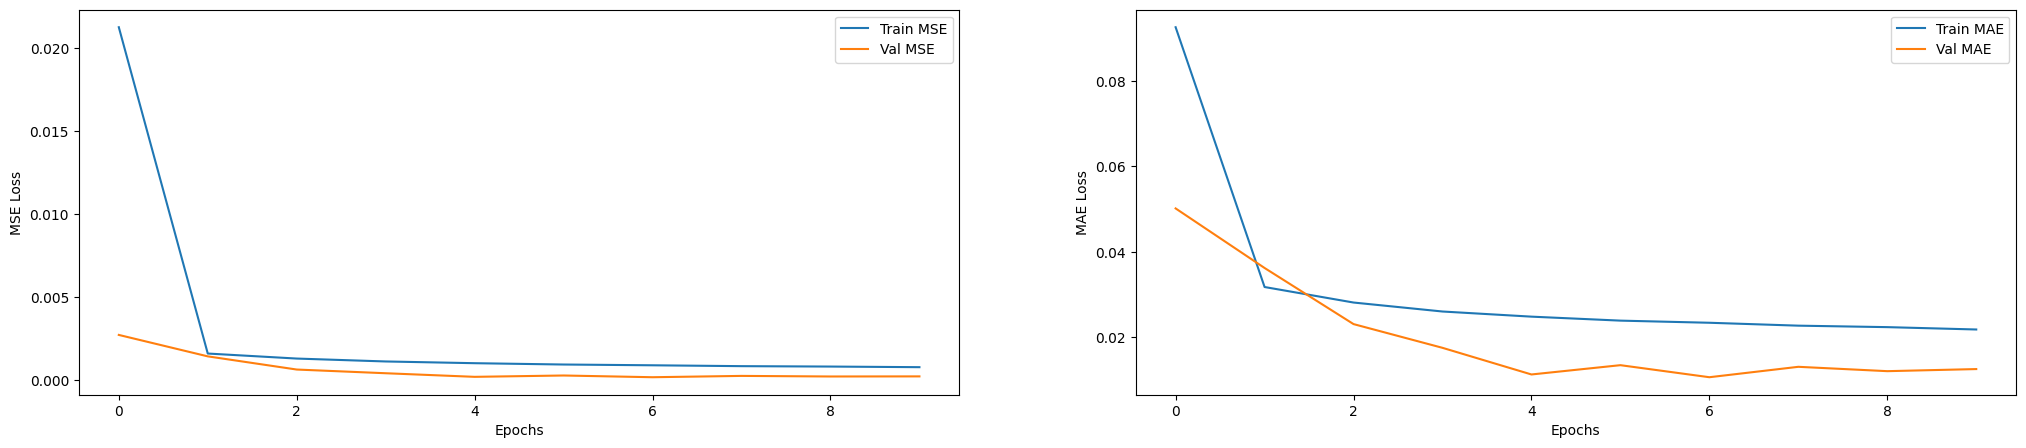

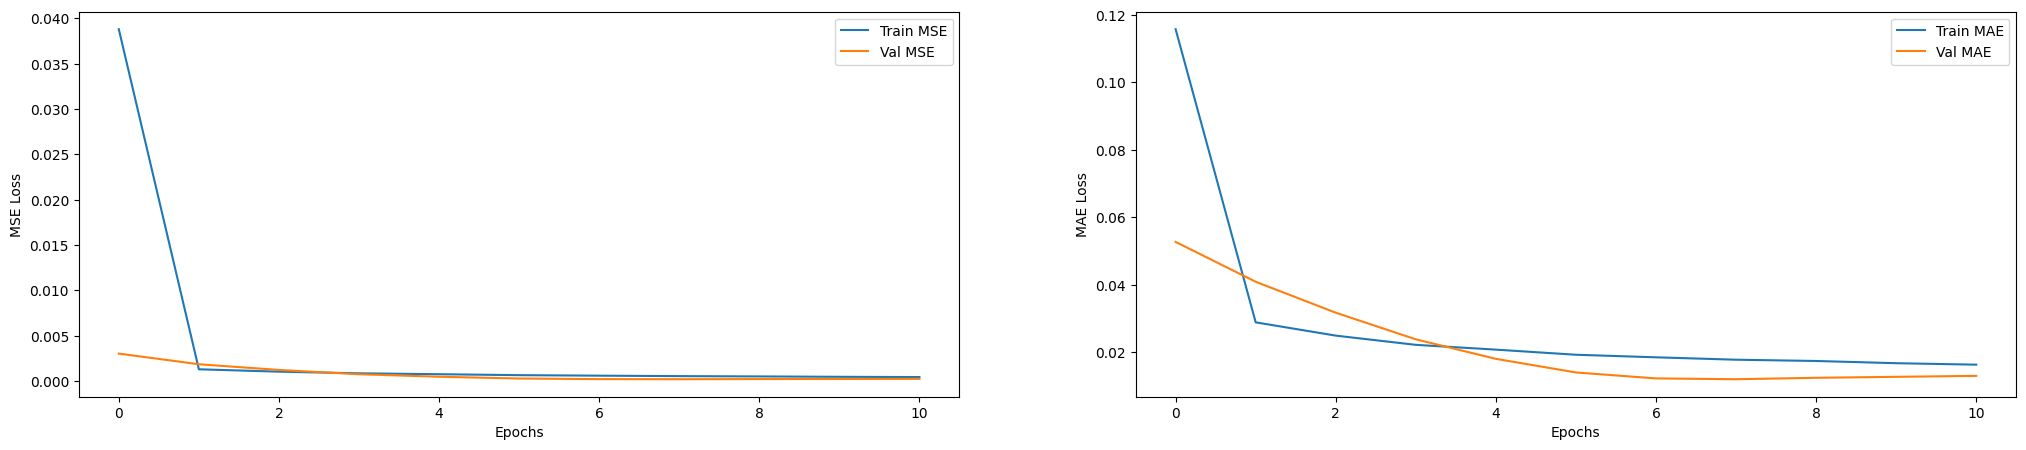

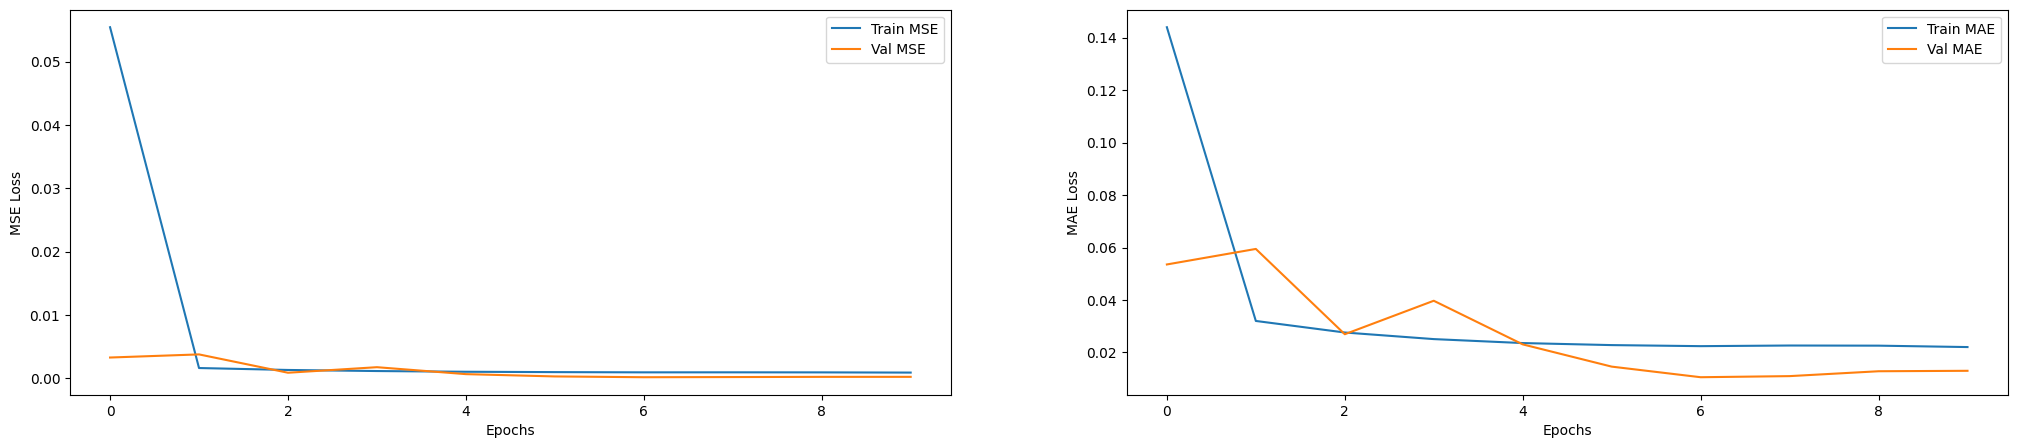

In [82]:
plot_metrics(history1)
plot_metrics(history2)
plot_metrics(history3)

In [83]:
print("Model 1: LSTM")
evaluate(model1)
print("-"*30)
print("Model 2: LSTM + CNN")
evaluate(model2)
print("-"*30)
print("Model 3: CNN")
evaluate(model3)

Model 1: LSTM
Ensemble d'entraînement:
MSE: 0.0004, MAE: 0.0163
Ensemble de validation:
MSE: 0.0002, MAE: 0.0107
Ensemble de test:
MSE: 0.0002, MAE: 0.0130
------------------------------
Model 2: LSTM + CNN
Ensemble d'entraînement:
MSE: 0.0005, MAE: 0.0174
Ensemble de validation:
MSE: 0.0002, MAE: 0.0119
Ensemble de test:
MSE: 0.0002, MAE: 0.0127
------------------------------
Model 3: CNN
Ensemble d'entraînement:
MSE: 0.0009, MAE: 0.0224
Ensemble de validation:
MSE: 0.0002, MAE: 0.0106
Ensemble de test:
MSE: 0.0003, MAE: 0.0134


## Predictions

In [84]:
last_values = df[-X_train.shape[1]:]
last_values = df_to_X(last_values,window_size=X_train.shape[1])

predictions1 = model1.predict(last_values)[0]
predictions2 = model2.predict(last_values)[0]
predictions3 = model3.predict(last_values)[0]

print(predictions1)
print(predictions2)
print(predictions3)

1/1 [==============================] - 0s 15ms/step
[0.71557456 0.7234157  0.7263579  0.7208834  0.7196124  0.720906
 0.7264719  0.71231306 0.72039914 0.725104   0.72456324 0.7230474
 0.72058094 0.7234078  0.7259409  0.72145414 0.71669906 0.7326679
 0.7200244  0.72439605 0.7223018  0.72183996 0.7227066  0.7283421
 0.7291782  0.7294603  0.7241385  0.72082    0.7228638  0.71653694
 0.7176777  0.7185249  0.7259666  0.725443   0.7187071  0.730641
 0.7261993  0.72436976 0.721539   0.7235092  0.72819096 0.7176185
 0.71106136 0.72408646 0.72703886 0.7176824  0.7212088  0.72332144
 0.7306628  0.7295567  0.71919787 0.7203464  0.71077925 0.72160804
 0.72650707 0.72558004 0.7254452  0.72420865 0.7222622  0.7269495
 0.72156346 0.722703   0.7165751  0.7204608  0.72146946 0.7176536
 0.71799254 0.72494406 0.7216836  0.73363906 0.7307187  0.71910477
 0.7190187  0.71722144 0.7279725  0.7238323  0.72484213 0.71730894
 0.72466964 0.7208028  0.72344524 0.7156372  0.7206332  0.72455716
 0.72534174 0.720162

In [85]:
final_predictions = [0]*100

for i in range(100):
    final_predictions[i] = (predictions1[i] + predictions2[i] + predictions3[i])/3

print(final_predictions)

[0.7256229718526205, 0.7266778945922852, 0.7299027442932129, 0.7283191680908203, 0.7266201972961426, 0.7278046607971191, 0.7217528820037842, 0.7238516012827555, 0.7228430112202963, 0.7264761924743652, 0.7238840262095133, 0.7276321252187093, 0.7235304514567057, 0.7264177004496256, 0.7261788050333658, 0.725289503733317, 0.722811222076416, 0.7316799163818359, 0.7284097671508789, 0.723974863688151, 0.7284399668375651, 0.725182851155599, 0.7321110566457113, 0.7291669845581055, 0.730032205581665, 0.7273475329081217, 0.727785587310791, 0.7254383563995361, 0.7251439094543457, 0.7218441963195801, 0.7284336090087891, 0.7249369621276855, 0.7276735305786133, 0.7262396812438965, 0.7323133945465088, 0.7341510454813639, 0.735556443532308, 0.728278636932373, 0.7341910203297933, 0.7317224343617758, 0.7317003409067789, 0.7250741322835287, 0.725019613901774, 0.7290419737497965, 0.7324865659077963, 0.7232474486033121, 0.7175999482472738, 0.7289783954620361, 0.7293910185496012, 0.7312541802724203, 0.727502

## CSV

In [86]:
predictions_with_header = [['Id','Prediction']]
for i, prediction in enumerate(final_predictions[:]):
    print(i,prediction)
    predictions_with_header.append([i,prediction])

# Écriture dans un fichier CSV
with open('predictionsN57.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(predictions_with_header)

print("Fichier CSV créé avec succès.")

0 0.7256229718526205
1 0.7266778945922852
2 0.7299027442932129
3 0.7283191680908203
4 0.7266201972961426
5 0.7278046607971191
6 0.7217528820037842
7 0.7238516012827555
8 0.7228430112202963
9 0.7264761924743652
10 0.7238840262095133
11 0.7276321252187093
12 0.7235304514567057
13 0.7264177004496256
14 0.7261788050333658
15 0.725289503733317
16 0.722811222076416
17 0.7316799163818359
18 0.7284097671508789
19 0.723974863688151
20 0.7284399668375651
21 0.725182851155599
22 0.7321110566457113
23 0.7291669845581055
24 0.730032205581665
25 0.7273475329081217
26 0.727785587310791
27 0.7254383563995361
28 0.7251439094543457
29 0.7218441963195801
30 0.7284336090087891
31 0.7249369621276855
32 0.7276735305786133
33 0.7262396812438965
34 0.7323133945465088
35 0.7341510454813639
36 0.735556443532308
37 0.728278636932373
38 0.7341910203297933
39 0.7317224343617758
40 0.7317003409067789
41 0.7250741322835287
42 0.725019613901774
43 0.7290419737497965
44 0.7324865659077963
45 0.7232474486033121
46 0.71